# Feature engineering

## Cargando librerías

In [17]:
import pandas as pd
import pickle
import datetime
import time
import numpy as np

In [35]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [87]:

from sklearn.tree import DecisionTreeClassifier

## Funciones de ingesta y transformación

In [3]:
# Funciones solicitadas

def load_ingestion(path='output/ingest_df.pkl'):
    """
    Recibe el path en donde se encuentra el pickle que generamos durante la ingestión.
    :param: path
    :return: pickle
    """
    # Recibe ingest_df.pkl
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def generate_label(df):
    """
    Crea en el data frame de los datos la variable label que es 1
    cuando el código de cierre es 'Pass','Pass w/ Conditions', 0 en caso de 'Fail'.
    :param: dataframe
    :return: dataframe
    """
    df['label'] = np.where(df.results.isin(['Pass','Pass w/ Conditions']), 1, 0)
    return df

def date_transformation(col, df):
    """
    Recibe la columna que hay que transformar a DATE y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return pd.to_datetime(df[col])

def numeric_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(float) 

def int_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(int)

def categoric_trasformation(col, df):
    """
    Recibe la columna que hay que transformar a CATEGORICA y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(str) 


def split_fecha(col, df):
    """
    Recibe la columna fecha que hay que transformar en 3 columnas: año, mes, dia y 
    el data frame al que pertenece.
    :param: column, dataframe
    :return: dataframe con 2 columnas mas (mes, día) y semanas
    """
    #df[col + '_año'] = df[col].dt.year.astype(str) 
    df[col + '_mes'] = df[col].dt.month.astype(str) 
    df[col + '_dia'] = df[col].dt.day.astype(str)     
    
    # Cambio a enteros
    df[col + '_mes'] = int_transformation(col + '_mes', df)
    df[col + '_dia'] = int_transformation(col + '_dia', df)
    # Como strings
    #df[col + '_mes'] = df[col + '_mes'].apply(two_dig)
    #df[col + '_dia'] = df[col + '_dia'].apply(two_dig)
    
    df['week'] = df[col].dt.week
    df['day_of_week'] = df[col].dt.day_name()
    
    return df
  
def save_transformation(df, path='output/transformation_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb)
    el data frame que ya tiene los datos transformados.
    El pickle se debe llamar transformation_df.pkl y se debe guardar
    en la carpeta output.
    :param: dataframe, path
    :return: file save
    """
    pickle.dump(df, open(path, "wb"))
    # utils function, debería guardar el pickle llamado transformation_df.pkl en la carpeta ouput
    # save_df(df, path)

## Funciones de feature enginering

In [47]:
# Funciones solicitadas

def load_transformation(path='output/transformation_df.pkl'): 
    """
    Recibe el path en donde se encuentra el pickle que generamos 
    durante la transformación.
    """
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def feature_generation(data): 
    """
    Recibe el data frame que contiene las variables a partir de las cuales 
    crearemos nuevas variables. Estas nuevas variables se guardarán en este 
    mismo data frame.
    """    
    
    # Para crear variables ciclícas
    data = ciclic_variables('day_of_week', data)
    data = ciclic_variables('week', data)
    data = ciclic_variables('inspection_date_mes', data)
    data = ciclic_variables('inspection_date_dia', data)
    
    # Variables posibles a transformar
    """
    'type','risk',zip','latitude','longitude',
    'sin_day_no','cos_day_no','sin_week','cos_week',
    'sin_month','cos_month','sin_days','cos_days'
    """
    
    # Variables a transformar
    data_input = pd.DataFrame(data,
                              columns=['type','risk','zip',#'results',
                                       'latitude','longitude',
                                       'sin_day_no','cos_day_no','sin_week','cos_week',
                                       'sin_month','cos_month','sin_days','cos_days'])
    # Transformaciones
    transformers_2 = [('one_hot', OneHotEncoder(), ['type','risk','zip']),#,'results']),
                      ('min_max', MinMaxScaler(), ['latitude','longitude',
                                                   'sin_day_no','cos_day_no','sin_week','cos_week',
                                                   'sin_month','cos_month','sin_days','cos_days'])]

    col_trans_2 = ColumnTransformer(transformers_2, remainder="drop", n_jobs=-1, verbose=True)
    col_trans_2.fit(data_input)

    input_vars = col_trans_2.transform(data_input)    
    # Solo para medir metricas
    pickle.dump(input_vars, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

    cols = ['bakery','catering','childern\'s service facility','daycare','golden diner','grocery','hospital',
            'long-term care','otros','restaurant', 'school',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            'latitude','longitude',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

    # Información del dataframe final
    df_final = pd.DataFrame(input_vars.todense())
    df_final.columns = cols    
        
    #df_final['inspection_date']= data['inspection_date']
    df_final['label']= data['label']

    return df_final
   
    
def feature_selection(data): 
    """
    Recibe el data frame que contiene las variables de las cuales haremos
    una selección.
    """
    X = data
    y = data.label
    X = pd.DataFrame(X.drop(['label'], axis=1))
    
    np.random.seed(20201124)

    ## Dividiendo datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=None)

    # ocuparemos un RF
    classifier = RandomForestClassifier(oob_score=True, random_state=1234)

    # Definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'n_estimators': [100, 300],
                        'max_depth': [1, 10, 15],
                        'min_samples_split': [2, 5]}

    tscv = TimeSeriesSplit(n_splits=3)
    
    # Ocupemos grid search!
    gs = GridSearchCV(classifier,
                      hyper_param_grid,
                      scoring='precision',
                      cv = tscv,
                      n_jobs = 3)

    # ejecutando el RF
    start_time = time.time()
    gs.fit(X_train, y_train)
    print("El proceso en segundos duro: ", time.time() - start_time)
    print("Mejores parámetros: " + str(gs.best_params_))
    print("Score:" + str(print(gs.best_score_)))
    best_e = gs.best_estimator_
    print("Mejor estimador: " + str(best_e))
    print("Mejor estimador observado: " + str(gs.best_estimator_.oob_score_))
    
    cols = ['bakery','catering','childern\'s service facility','daycare','golden diner','grocery','hospital',
            'long-term care','otros','restaurant', 'school',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            'latitude','longitude',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']


    # Importancia de los parámetros
    feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                       'feature': list(cols)})
    print("Importancia de los parámetros")
    print(feature_importance.sort_values(by="importance", ascending=False))

    # Salvando el mejor modelo obtenido
    #save_fe(best_e, path='../output/feature_selection_model_DPA.pkl')
    save_fe(best_e, path='output/feature_selection_model_DPA.pkl')

    # Regresando dataframe con los features que ocuparemos.
    # En este caso las variables que aportan más del 7% de información son:
    final_df = data[[
                            # Variables que aportan 7%
                            'latitude','longitude','sin_days','cos_days',
                            'sin_week','cos_week',
                            # Variables que aportan 4% y 3%
                            'sin_day_no','cos_day_no','sin_month','cos_month',
                            # Variables que aportan 1.5% aprox
                            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
                            'bakery','catering','childern\'s service facility',
                            'daycare','golden diner','grocery','hospital',
                            'long-term care','otros','restaurant', 'school',
                            'label'
                         ]]    

    return final_df

    
def save_fe(df, path='output/fe_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb) el data frame 
    que ya tiene los features que ocuparemos. El pickle se debe llamar fe_df.pkl y 
    se debe guardar en la carpeta output.
    """    
    pickle.dump(df, open(path, "wb"))##en jupyter
    # utils function, debería guardar el picjle llamado fe_df.pkl en la carpeta ouput
    #save_df(df, path)# en .py
    

# --------------------- Funciones Auxiliares ---------------------------    
def ciclic_variables(col, df):
    """
    Recibe la columna day_no, mes o fecha_creacion y las convierte en variables cíclicas:
    número día de la semana, mes, semana y hora respectivamente.
    :param: column, dataframe
    :return: dataframe con variable cíclica creada corresondientemente
    """
    
    if (col == 'day_of_week'):
        no_dia_semana = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 
                         'Thursday':5, 'Friday':6, 'Saturday':7}
        df['day_no'] = df[col].apply(lambda x: no_dia_semana[x])
        #max_day_no = np.max(df['day_no'])
        max_day_no = 7
        df['sin_day_no'] = np.sin(2*np.pi*df['day_no']/max_day_no)
        df['cos_day_no'] = np.cos(2*np.pi*df['day_no']/max_day_no)
        
    if(col == 'week'):
        # converting the hour into a sin, cos coordinate
        WEEKS = 53
        df['sin_week'] = np.sin(2*np.pi*df[col]/WEEKS)
        df['cos_week'] = np.cos(2*np.pi*df[col]/WEEKS) 
        
    if(col == 'inspection_date_mes'):
        MONTH = 12
        df['sin_month'] = np.sin(2*np.pi*df[col]/MONTH)
        df['cos_month'] = np.cos(2*np.pi*df[col]/MONTH) 
        
    if(col == 'inspection_date_dia'):
        # converting the hour into a sin, cos coordinate
        DAYS = 31
        df['sin_days'] = np.sin(2*np.pi*df[col]/DAYS)
        df['cos_days'] = np.cos(2*np.pi*df[col]/DAYS)    
            
    return df
    


In [5]:
def clean(df):
    """
    Recibe un dataframe y le aplica limpieza de datos
    :param: dataframe
    :return: dataframe
    """
    # Nos quedamos sólo con los resultados 'Pass','Pass w/ Conditions', 'Fail
    df = df[df.results.isin(['Pass','Pass w/ Conditions', 'Fail'])]
    
    # Podemos tomar sólo los de tipo Canvass (Sondeo)
    df = df[df.inspection_type.isin(['Canvass'])]
    
    # Generamos el label
    df = generate_label(df)
    
    # Quitamos NA
    df = df[df['facility_type'].notna()]
    df = df[df['risk'].notna()]
    df = df[df['city'].notna()]
    df = df[df['state'].notna()]
    df = df[df['zip'].notna()]
    df = df[df['latitude'].notna()]
    df = df[df['longitude'].notna()]
    df = df[df['location'].notna()]
    
    # Nos quedamos con las variables para predecir 
    df = df[['facility_type','risk','address','zip',
             'inspection_date','latitude','longitude','label']]
    
    # Quitamos duplicados
    df = df.drop_duplicates()
    
    # Agrupamos establecimientos
    df = agrupa_tipos(df)    
    
    return df



def agrupa_tipos(df_final):
    """
    Agrupa los tipos de establecimientos (300 a 11 tipos)
    :param: dataframe
    :return: dataframe
    """
    # Se pasa a minusculas
    df_final["facility_type"] = df_final["facility_type"].str.lower().str.strip()
    # Se hace una copia de la variable
    df_final["type"] = df_final["facility_type"]
    # Comenzamos a agrupar
    df_final['type'] = df_final['type'].replace(["1023",
                                    "1023 childern\'s service facility",
                                    "1023 childern\'s service s facility",
                                    "1023 childern's services facility", 
                                    "1023 children's services facility",
                                    "1023-children's services facility",
                                    "childern's service facility",
                                    "children's services facility",
                                    "childrens services facility"],"childern\'s service facility")

    df_final['type'] = df_final['type'].replace(["convenience/gas station",
                                    "gas station",
                                    "gas station /grocery",
                                    "gas station store",
                                    "gas station/ grocery store",
                                    "gas station/convenience store",
                                    "gas station/food",
                                    "gas station/grocery",
                                    "gas station/mini mart",
                                    "gas station/restaurant",
                                    "gas station/store",
                                    "gas station/store grocery",
                                    "grocery store / gas station",
                                    "grocery store/gas station",
                                    "grocery/gas station",
                                    "grocery/service gas station",
                                    "retail food/gas station",
                                    "service gas station"],"gas station")

    df_final['type'] = df_final['type'].replace(["restaurant",
                                    " restaurant\'","restaurant\'",
                                    "grocery& restaurant",
                                    "restaurant.banquet halls",
                                    "restaurant(protein shake bar)",
                                    "restaurant/bakery",
                                    "restaurant/bar",
                                    "restaurant/grocery",
                                    "restaurant/grocery store",
                                    "restaurant/hospital",
                                    "grocery & restaurant",
                                    "restuarant and bar"],"restaurant")

    df_final['type'] = df_final['type'].replace(["bakery/ restaurant",
                                    "bakery/restaurant",
                                    "bakery",
                                    "bakery/deli",],"bakery")

    df_final['type'] = df_final['type'].replace(["deli/grocery store",
                                    "grocery",
                                    "grocery and butcher",
                                    "grocery store",
                                    "grocery store/ restaurant",
                                    "grocery store/bakery",
                                    "grocery store/cooking school",
                                    "grocery store/taqueria",
                                    "grocery(sushi prep)",
                                    "grocery/ restaurant",
                                    "grocery/bakery",
                                    "grocery/butcher",
                                    "grocery/dollar store",
                                    "grocery/drug store",
                                    "grocery/liquor store",
                                    "grocery/restaurant",
                                    "grocery/taqueria",
                                    "slaughter house/ grocery"],"grocery")

    df_final['type'] = df_final['type'].replace(["juice and salad bar",
                                    "juice bar",
                                    "juice bar/grocery"],"juice bar")

    df_final['type'] = df_final['type'].replace(["assissted living",
                                    "assisted living",
                                    "assisted living senior care"],"assisted living")

    df_final['type'] = df_final['type'].replace(["banquet",
                                    "banquet dining",
                                    "banquet facility",
                                    "banquet hall",
                                    "banquet hall/catering",
                                    "banquet room",
                                    "banquet rooms",
                                    "banquet/kitchen",
                                    "banquets",
                                    "banquets/room service",
                                    "bowling lanes/banquets",
                                    "lounge/banquet hall"],"banquet")

    df_final['type'] = df_final['type'].replace(["bar","bar/grill","smoothie bar",
                                    "wine tasting bar"],"bar")

    df_final['type'] = df_final['type'].replace(["candy shop",
                                    "candy store",
                                    "candy/gelato"],"candy")

    df_final['type'] = df_final['type'].replace(["charter",
                                    "charter school",
                                    "charter school cafeteria"],"charter")

    df_final['type'] = df_final['type'].replace(["church",
                                    "church (special events)",
                                    "church kitchen",
                                    "church/day care",
                                    "church/special events"],"church")

    df_final['type'] = df_final['type'].replace(["(convenience store)",
                                    "convenience",
                                    "convenience store",
                                    "convenience/drug store",
                                    "convenient store",
                                    "convnience store"],"convenience")

    df_final['type'] = df_final['type'].replace(["cafe/store",
                                    "cafeteria",
                                    "coffee  shop",
                                    "coffee cart",
                                    "coffee kiosk",
                                    "coffee shop",
                                    "coffee/tea",
                                    "school cafeteria",
                                    "university cafeteria"],"cafeteria")

    df_final['type'] = df_final['type'].replace(["catering",
                                    "catering/banquet",
                                    "catering/cafe"],"catering")

    df_final['type'] = df_final['type'].replace(["commiasary",
                                    "commisary restaurant",
                                    "commissary",
                                    "commissary for soft serve ice cream trucks"],
                                    "commisary")

    df_final['type'] = df_final['type'].replace(["day care 1023",
                                    "day care 2-14",
                                    "daycare",
                                    "daycare (2 - 6 years)",
                                    "daycare (2 years)",
                                    "daycare (under 2 years)",
                                    "daycare 2 yrs to 12 yrs",
                                    "daycare above and under 2 years",
                                    "daycare combo 1586",
                                    "daycare night",
                                    "15 monts to 5 years old"],"daycare")

    df_final['type'] = df_final['type'].replace(["adult daycare","senior day care"],"adult daycare")

    df_final['type'] = df_final['type'].replace(["dollar store","dollar store with grocery"],"dollar store")

    df_final['type'] = df_final['type'].replace(["health care store","health center"],"health")

    df_final['type'] = df_final['type'].replace(["herbal",
                                    "herbal drinks",
                                    "herbal life shop",
                                    "herbal medicine",
                                    "herbal remedy",
                                    "herbal store"],"herbal")

    df_final['type'] = df_final['type'].replace(["herbalife",
                                    "herbalife nutrition",
                                    "herbalife/zumba"],"herbalife")

    df_final['type'] = df_final['type'].replace(["ice cream",
                                    "ice cream shop",
                                    "paleteria",
                                    "paleteria /icecream shop"],"ice cream")

    df_final['type'] = df_final['type'].replace(["liquor",
                                    "liquor store",
                                    "liquor/coffee kiosk",
                                    "liquor/grocery store/bar"],"liquor")

    df_final['type'] = df_final['type'].replace(["long term care",
                                    "long term care facility",
                                    "long-term care",
                                    "long-term care facility"],"long-term care")

    df_final['type'] = df_final['type'].replace(["mobile food dispenser",
                                    "mobile food preparer"],"mobile food")

    df_final['type'] = df_final['type'].replace(["movie theater","movie theatre"],"movie theater")

    df_final['type'] = df_final['type'].replace(["non -profit","not-for-profit club"],"non -profit")

    df_final['type'] = df_final['type'].replace(["rest/grocery",
                                    "rest/gym",
                                    "rest/rooftop"],"rest")

    df_final['type'] = df_final['type'].replace(["roof top",
                                    "roof tops",
                                    "rooftop",
                                    "rooftops"],"roof top")

    df_final['type'] = df_final['type'].replace(["shared kitchen",
                                    "shared kitchen user (long term)",
                                    "shared kitchen user (short term)"],"shared kitchen")

    df_final['type'] = df_final['type'].replace(["summer feeding","summer feeding prep area"],"summer feeding")

    df_final['type'] = df_final['type'].replace(["supportive living","supportive living facility"],"supportive living")

    df_final['type'] = df_final['type'].replace(["tavern","tavern grill","tavern/restaurant"],"tavern")

    df_final['type'] = df_final['type'].replace(["theater","theater ","theatre"],"theater")

    df_final['type'] = df_final['type'].replace(["wrigley roof top","wrigley rooftop"],"wrigley roof top")

    df_final['type'] = df_final['type'].replace(["culinary arts school",
                                    "culinary class rooms",
                                    "culinary school"],"culinary")

    df_final['type'] = df_final['type'].replace(["drug store",
                                    "drug store/grocery",
                                    "drug treatment facility",
                                    "drug/food store"],"drug store")

    df_final['type'] = df_final['type'].replace([ "gas station","shelter","liquor","wholesale","nursing home",
                                                  "after school program","shared kitchen","incubator","cafeteria",
                                                  "theater","tavern","assisted living","cooking school","pool",
                                                  "special event","candy","convenience","kiosk","commisary",
                                                  "culinary","banquet","public shcool","private school",
                                                  "mobile food","ice cream","cold/frozen food storage","church",
                                                  "summer feeding","non -profit","rest","city of chicago college",
                                                  "a-not-for-profit chef training program","employee kitchen",
                                                  "room service","pantry","main kitchen",
                                                  "prepackage meal distributor (1006 retail)","fitness center",
                                                  "o'hare kiosk","live poultry","pastry school",
                                                  "charity aid kitchen","snack shop","newsstand","butcher shop",
                                                  "dollar store","bar","weight loss program","meat packing",
                                                  "teaching school","nutrition store","social club","health",
                                                  "before and after school program","adult daycare","video store",
                                                  "deli","juice bar","drug store","donut shop","hot dog station",
                                                  "popcorn shop","boys and girls club","stadium","fish market",
                                                  "smokehouse","college","chinese herbs","blockbuster video",
                                                  "wrigley roof top","roof top","navy pier kiosk","herbal",
                                                  "beverage/silverware warehouse","supportive living",
                                                  "rehab center","unused storage","repackaging plant","day spa",
                                                  "custom poultry slaughter","night club","music venue","other",
                                                  "charter","movie theater","retail store offers cooking classes",
                                                  "northerly island","store","gelato shop","packaged liquor",
                                                  "vfw hall","regulated business","cell phone store","hotel",
                                                  "prepacakaged foods","warehouse","golf course conncession stand",
                                                  "brewpub","riverwalk","kitchen demo","herbalife","dining hall",
                                                  "hostel","theater","airport lounge","poultry slaughter",
                                                  "prep inside school","french market space","gym store",
                                                  "distribution center","youth housing","sushi counter","brewery",
                                                  "event space","packaged health foods","art center",
                                                  "shakes/teas","theater & restaurant"],"otros")

    return df_final

# Transformation.py

## Carga de datos

In [6]:
data = pickle.load(open('output/2020-02-02_.pkl', "rb"))
data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2484780,RED STAR LIQUORS,RED STAR LIQUORS,2432531,Grocery Store,Risk 2 (Medium),2725-2727 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass,57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAIN...,41.93078708970233,-87.70998753402094,"{'latitude': '-87.70998753402094', 'longitude'..."
1,2484768,MARZ COMMINITY BREWING CO.,MARZ COMMUNITY BREWING CO.,2770949,Liquor,Risk 3 (Low),1950 N WESTERN AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.917134801370274,-87.68754385201615,"{'latitude': '-87.68754385201615', 'longitude'..."
2,2484766,LA FORTALEZA DE ARCELIA GUERRERO,LA FORTALEZA DE ARCELIA GUERRERO,2575370,Restaurant,Risk 1 (High),5958 W DIVERSEY AVE,CHICAGO,IL,60639,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass w/ Conditions,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.931249818095836,-87.7759069982422,"{'latitude': '-87.7759069982422', 'longitude':..."
3,2484759,Jimmy Johns,Jimmy Johns,1898470,Restaurant,Risk 1 (High),51 W DIVISION ST,CHICAGO,IL,60610,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.903806014540685,-87.63058113117621,"{'latitude': '-87.63058113117621', 'longitude'..."
4,2484775,CAFE TOLA #4,CAFE TOLA,2627325,Restaurant,Risk 1 (High),2489 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.92663502691596,-87.70319925259288,"{'latitude': '-87.70319925259288', 'longitude'..."


In [7]:
df_final = clean(data)

### Iniciamos transformaciones de datos

In [8]:
# Categoricas
df_final['type'] = categoric_trasformation('type', df_final)
df_final['facility_type'] = categoric_trasformation('facility_type', df_final)
df_final['risk'] = categoric_trasformation('risk', df_final)
df_final['address'] = categoric_trasformation('address', df_final)
df_final['zip'] = categoric_trasformation('zip', df_final)
# Númericas 
df_final['label'] = int_transformation('label', df_final)
df_final['latitude'] = numeric_transformation('latitude', df_final)
df_final['longitude'] = numeric_transformation('longitude', df_final)

In [9]:
# Transformando fechas.
df_final['inspection_date'] = date_transformation('inspection_date', df_final)
# Dividiendo fecha en mes y día, y creando semanas
df_final = split_fecha("inspection_date", df_final)

/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [10]:
# Ordenando datos por fecha de inspección
df_final = df_final.sort_values(['inspection_date'])
df_final

,facility_type,risk,address,zip,inspection_date,latitude,longitude,label,type,inspection_date_mes,inspection_date_dia,week,day_of_week
216264,restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,41.898431,-87.628009,0,restaurant,1,4,1,Monday
216194,restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,41.804468,-87.723633,1,restaurant,1,5,1,Tuesday
216200,restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,42.011357,-87.806788,1,restaurant,1,5,1,Tuesday
216210,school,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,41.917384,-87.717464,1,school,1,5,1,Tuesday
216216,restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,41.894165,-87.629389,1,restaurant,1,5,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,41.851934,-87.701132,1,restaurant,2,10,6,Wednesday
24,restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,41.896103,-87.672116,0,restaurant,2,10,6,Wednesday
15,restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,41.909960,-87.710429,0,restaurant,2,10,6,Wednesday
13,restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,41.851939,-87.700898,1,restaurant,2,10,6,Wednesday


In [20]:
df_final = df_final.reset_index(drop=True)
df_final

,facility_type,risk,address,zip,inspection_date,latitude,longitude,label,type,inspection_date_mes,...,day_of_week,day_no,sin_day_no,cos_day_no,sin_week,cos_week,sin_month,cos_month,sin_days,cos_days
0,restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,41.898431,-87.628009,0,restaurant,1,...,Monday,2,0.974928,-0.222521,0.118273,0.992981,0.500000,0.866025,0.724793,0.688967
1,restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,41.804468,-87.723633,1,restaurant,1,...,Tuesday,3,0.433884,-0.900969,0.118273,0.992981,0.500000,0.866025,0.848644,0.528964
2,restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,42.011357,-87.806788,1,restaurant,1,...,Tuesday,3,0.433884,-0.900969,0.118273,0.992981,0.500000,0.866025,0.848644,0.528964
3,school,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,41.917384,-87.717464,1,school,1,...,Tuesday,3,0.433884,-0.900969,0.118273,0.992981,0.500000,0.866025,0.848644,0.528964
4,restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,41.894165,-87.629389,1,restaurant,1,...,Tuesday,3,0.433884,-0.900969,0.118273,0.992981,0.500000,0.866025,0.848644,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87014,restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,41.851934,-87.701132,1,restaurant,2,...,Wednesday,4,-0.433884,-0.900969,0.652822,0.757511,0.866025,0.500000,0.897805,-0.440394
87015,restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,41.896103,-87.672116,0,restaurant,2,...,Wednesday,4,-0.433884,-0.900969,0.652822,0.757511,0.866025,0.500000,0.897805,-0.440394
87016,restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,41.909960,-87.710429,0,restaurant,2,...,Wednesday,4,-0.433884,-0.900969,0.652822,0.757511,0.866025,0.500000,0.897805,-0.440394
87017,restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,41.851939,-87.700898,1,restaurant,2,...,Wednesday,4,-0.433884,-0.900969,0.652822,0.757511,0.866025,0.500000,0.897805,-0.440394


In [22]:
# Salvando dataframe transformado
pickle.dump(df_final, open("output/transformation_df_DPA.pkl", "wb"))

### Frecuencias tipo de establecimientos

In [12]:
prop_codigo = df_final.groupby(['facility_type'], as_index=False)['inspection_date']\
.count()\
.rename(columns={'inspection_date': 'count'})
prop_codigo['prop'] = prop_codigo['count']/np.sum(prop_codigo['count'])
prop_codigo.sort_values(by = ['prop'], ascending = False).head(60)

,facility_type,count,prop
219,restaurant,59765,0.686804
236,school,9607,0.110401
129,grocery store,8856,0.101771
16,bakery,1473,0.016927
54,children's services facility,1184,0.013606
89,daycare (2 - 6 years),835,0.009596
93,daycare above and under 2 years,830,0.009538
177,long term care,829,0.009527
45,catering,600,0.006895
124,golden diner,441,0.005068


In [13]:
p = df_final.groupby(['type'], as_index=False)['inspection_date']\
.count()\
.rename(columns={'inspection_date': 'count'})
p['prop'] = p['count']/np.sum(p['count'])
p.sort_values(by = ['prop'], ascending = False).head(60)

,type,count,prop
9,restaurant,59830,0.687551
10,school,9607,0.110401
5,grocery,8948,0.102828
3,daycare,1961,0.022535
8,otros,1799,0.020674
0,bakery,1480,0.017008
2,childern's service facility,1222,0.014043
7,long-term care,839,0.009642
1,catering,608,0.006987
4,golden diner,441,0.005068


# Feature_engineering.py

In [32]:
# Carga pickle para feature generation
df_transform = load_transformation('output/transformation_df_DPA.pkl')
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87019 entries, 0 to 87018
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   facility_type        87019 non-null  object        
 1   risk                 87019 non-null  object        
 2   address              87019 non-null  object        
 3   zip                  87019 non-null  object        
 4   inspection_date      87019 non-null  datetime64[ns]
 5   latitude             87019 non-null  float64       
 6   longitude            87019 non-null  float64       
 7   label                87019 non-null  int64         
 8   type                 87019 non-null  object        
 9   inspection_date_mes  87019 non-null  int64         
 10  inspection_date_dia  87019 non-null  int64         
 11  week                 87019 non-null  int64         
 12  day_of_week          87019 non-null  object        
 13  day_no               87019 non-

In [48]:
#in_v, fe_df = feature_generation(df_transform)
fe_df = feature_generation(df_transform)
fe_df

,bakery,catering,childern's service facility,daycare,golden diner,grocery,hospital,long-term care,otros,restaurant,...,longitude,sin_day_no,cos_day_no,sin_week,cos_week,sin_month,cos_month,sin_days,cos_days,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.735664,1.000000,3.568959e-01,0.559163,0.996487,0.750000,0.933013,0.862862,0.844083,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.490056,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.276472,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.505900,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.732120,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.547848,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,1
87015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.622376,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,0
87016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.523969,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,0
87017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.548451,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,1


In [38]:
df = feature_selection(fe_df)
df

El proceso en segundos duro:  146.2891685962677
Mejores parámetros: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
0.7813041510346599
Score:None
Mejor estimador: RandomForestClassifier(max_depth=15, oob_score=True, random_state=1234)
Mejor estimador observado: 0.7854480981071364
Importancia de los parámetros
    importance    feature
74    0.143974   latitude
75    0.139454  longitude
82    0.089084   sin_days
83    0.078485   cos_days
78    0.076687   sin_week
..         ...        ...
43    0.000573      60630
72    0.000568      60707
54    0.000400      60642
66    0.000356      60656
40    0.000008      60627

[84 rows x 2 columns]


,latitude,longitude,sin_days,cos_days,sin_week,cos_week,sin_day_no,cos_day_no,sin_month,cos_month,...,childern's service facility,daycare,golden diner,grocery,hospital,long-term care,otros,restaurant,school,label
0,0.674190,0.735664,0.862862,0.844083,0.559163,0.996487,1.000000,3.568959e-01,0.750000,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.424550,0.490056,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.974211,0.276472,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.724543,0.505900,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.662856,0.732120,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87014,0.550658,0.547848,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
87015,0.668003,0.622376,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
87016,0.704819,0.523969,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
87017,0.550669,0.548451,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [39]:
# Se salva el dataframe con los features
save_fe(df, 'output/fe_df_DPA.pkl')

# DETALLE DEL FEATURE SELECTION

In [49]:
in_v = pickle.load(open('output/feature_selection_input_vars_DPA.pkl', "rb"))

In [50]:
from sklearn.feature_selection import VarianceThreshold

In [51]:
variance_threshold = VarianceThreshold(threshold=0.1)
variance_threshold.fit(in_v)
variance_threshold.transform(in_v).todense()

matrix([[1.        , 1.        , 0.        , ..., 0.9330127 , 0.86286212,
         0.84408348],
        [1.        , 1.        , 0.        , ..., 0.9330127 , 0.92486744,
         0.76387627],
        [1.        , 1.        , 0.        , ..., 0.9330127 , 0.92486744,
         0.76387627],
        ...,
        [1.        , 1.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062],
        [1.        , 0.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062],
        [0.        , 1.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062]])

In [52]:
variance_threshold.variances_

array([1.67185153e-02, 6.93816197e-03, 1.38457068e-02, 2.20274683e-02,
       5.04217555e-03, 9.22544961e-02, 3.25300362e-03, 9.54861261e-03,
       2.02462463e-02, 2.14824624e-01, 9.82127569e-02, 1.63023166e-01,
       1.38450494e-01, 3.75453114e-02, 1.89886388e-02, 8.58969604e-03,
       1.06967936e-02, 7.79856720e-03, 1.57517422e-02, 2.13575749e-02,
       2.72319249e-02, 2.59282851e-02, 1.98935802e-02, 2.06316652e-02,
       3.15391801e-02, 1.39797157e-02, 2.42278673e-02, 3.72591843e-02,
       8.86064229e-03, 2.08847644e-02, 1.77719038e-02, 3.17110252e-02,
       1.19319483e-02, 1.38345377e-02, 6.58676916e-03, 3.16036299e-02,
       2.57759460e-02, 8.86064229e-03, 2.80122832e-02, 1.65963901e-02,
       1.14916111e-05, 1.43703576e-02, 1.87344948e-02, 1.52286308e-02,
       9.16527498e-03, 2.60805724e-02, 2.02990123e-03, 2.30140409e-02,
       7.91166484e-03, 9.99920716e-03, 1.43257292e-02, 2.33971302e-02,
       2.57106420e-02, 2.09287673e-02, 1.19768028e-02, 1.49389994e-02,
      

In [53]:
X = in_v
y = fe_df.label.values.reshape(in_v.shape[0],)
print(X.shape, y.shape)

(87019, 84) (87019,)


In [54]:
np.random.seed(20201124)

In [55]:
# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [56]:
# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [100, 300], 
                    'max_depth': [1, 10, 15],
                    'min_samples_split': [2, 5]}

In [57]:
# ocupemos grid search!
tscv = TimeSeriesSplit(n_splits=3)
    
# Ocupemos grid search!
gs = GridSearchCV(classifier,
                  hyper_param_grid,
                  scoring='precision',
                  cv = tscv,
                  n_jobs = 3)#2

In [58]:
# ejecutando el RF
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  188.18521165847778


**Mejores parámetros:**

In [60]:
gs.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

**Score:**

In [61]:
gs.best_score_

0.7776182720148445

**Mejor estimador:**

In [62]:
best_e = gs.best_estimator_
best_e

RandomForestClassifier(max_depth=15, oob_score=True, random_state=1234)

**feature_importances**

In [63]:
best_e.feature_importances_

array([0.00458769, 0.00170222, 0.00605171, 0.00539741, 0.00182859,
       0.01618612, 0.00123481, 0.00273873, 0.00590604, 0.01498901,
       0.00933513, 0.01427493, 0.0140879 , 0.00996376, 0.0054323 ,
       0.00086331, 0.0007949 , 0.0004904 , 0.00090629, 0.00386883,
       0.00098285, 0.00109953, 0.00210792, 0.00106771, 0.00228192,
       0.00099168, 0.00116902, 0.00198789, 0.00870501, 0.00197771,
       0.00229376, 0.0042363 , 0.00605882, 0.00376693, 0.0018863 ,
       0.001282  , 0.00457297, 0.00288335, 0.00139059, 0.00216418,
       0.        , 0.00543392, 0.00209947, 0.00137516, 0.00097474,
       0.00088387, 0.0005853 , 0.0024762 , 0.00283113, 0.00533837,
       0.00752114, 0.00280393, 0.00378335, 0.00113665, 0.00051339,
       0.00106487, 0.00271279, 0.00148819, 0.0016748 , 0.00134536,
       0.00142445, 0.00133013, 0.00218288, 0.00105878, 0.00432589,
       0.00070664, 0.00079723, 0.00105707, 0.00233388, 0.00155016,
       0.00082275, 0.00108658, 0.00095568, 0.00039924, 0.14419

In [64]:
cols = ['bakery','catering','childern\'s service facility','daycare','golden diner','grocery','hospital',
            'long-term care','otros','restaurant', 'school',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            'latitude','longitude',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

In [65]:
feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                  'feature': cols})

**Nombre de los campos con mayor importancia**

In [66]:
feature_importance.sort_values(by="importance", ascending=False).head(30)

,importance,feature
74,0.144196,latitude
75,0.138442,longitude
82,0.087707,sin_days
83,0.078735,cos_days
78,0.074868,sin_week
79,0.074022,cos_week
76,0.048717,sin_day_no
81,0.041113,cos_month
80,0.040238,sin_month
77,0.032343,cos_day_no


In [67]:
gs.best_estimator_.oob_score_

0.7777321753976983

In [68]:
predicted_labels = gs.predict(X_test)

In [69]:
predicted_scores = gs.predict_proba(X_test)

In [70]:
predicted_scores[:10]

array([[0.18118648, 0.81881352],
       [0.19798364, 0.80201636],
       [0.21331679, 0.78668321],
       [0.1432135 , 0.8567865 ],
       [0.2006784 , 0.7993216 ],
       [0.22628753, 0.77371247],
       [0.26095829, 0.73904171],
       [0.24078716, 0.75921284],
       [0.24108901, 0.75891099],
       [0.213861  , 0.786139  ]])

**Guardando el mejor estimador**

In [60]:
#pickle.dump(best_e, open("output/feature_selection_model_DPA.pkl", "wb"))
#pickle.dump(gs, open("output/feature_selection_estimadores_DPA.pkl", "wb"))
#pickle.dump(in_v, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

**Ahora se puede trabajar con el estimador obtenido sin volver a correr todo**

In [71]:
# Carga pickle
load_best_e = load_transformation('output/feature_selection_model_DPA.pkl')
load_best_e

RandomForestClassifier(max_depth=15, oob_score=True, random_state=1234)

In [72]:
final_df = pd.DataFrame(in_v.todense())
final_df.columns = cols

**Imprimiendo todos los fuatures por nivel de importancia**

In [73]:
feature_importance = pd.DataFrame({'importance': load_best_e.feature_importances_,
                                  'feature': list(final_df.columns)})
feature_importance.sort_values(by="importance", ascending=False).head(30)

,importance,feature
74,0.143974,latitude
75,0.139454,longitude
82,0.089084,sin_days
83,0.078485,cos_days
78,0.076687,sin_week
79,0.073761,cos_week
76,0.046480,sin_day_no
80,0.041738,sin_month
81,0.039718,cos_month
77,0.032514,cos_day_no


In [74]:
feature_importance.sort_values(by="importance", ascending=False).tail(21)

,importance,feature
46,0.000904,60633
55,0.000867,60643
53,0.000861,60641
25,0.000849,60612
15,0.000810,60602
38,0.000808,60625
51,0.000752,60639
26,0.000725,60613
67,0.000704,60657
65,0.000680,60655


**Guardando el Dataframe con los features seleccionados**

In [65]:
#pickle.dump(final_df, open("output/fe_df_DPA.pkl", "wb"))

Vericicando que se haya guardado

In [75]:
df_fe = pickle.load(open('output/fe_df_DPA.pkl', "rb"))
df_fe.head(5)

,latitude,longitude,sin_days,cos_days,sin_week,cos_week,sin_day_no,cos_day_no,sin_month,cos_month,...,childern's service facility,daycare,golden diner,grocery,hospital,long-term care,otros,restaurant,school,label
0,0.674190,0.735664,0.862862,0.844083,0.559163,0.996487,1.000000,3.568959e-01,0.75,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.424550,0.490056,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.974211,0.276472,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.724543,0.505900,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.662856,0.732120,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### Métricas de desempeño 

#### ROC y AUC

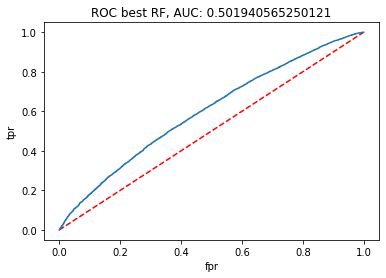

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

#### Matriz de confusión

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

array([[   29,  5756],
       [   23, 20298]])

#### Accuracy

In [78]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, predicted_labels)

0.7786332643836665

In [79]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [80]:
thresholds_2 = np.append(thresholds_2, 1)

In [81]:
(precision.shape, recall.shape, thresholds_2.shape)

((25731,), (25731,), (25731,))

#### Reporte de métricas

In [82]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [83]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.365093,0.778433,1.000000,0.875415,1.000000,0.999827,0.000173,0.000000
1,0.385663,0.778416,0.999902,0.875366,0.999902,0.999827,0.000173,0.000098
2,0.389754,0.778476,0.999902,0.875404,0.999902,0.999481,0.000519,0.000098
3,0.419369,0.778565,0.999902,0.875460,0.999902,0.998963,0.001037,0.000098
4,0.446039,0.778523,0.999656,0.875339,0.999656,0.998963,0.001037,0.000344
...,...,...,...,...,...,...,...,...
9210,0.938466,0.888889,0.000394,0.000787,0.000394,0.000173,0.999827,0.999606
9211,0.938545,0.857143,0.000295,0.000590,0.000295,0.000173,0.999827,0.999705
9212,0.939136,0.833333,0.000246,0.000492,0.000246,0.000173,0.999827,0.999754
9213,0.939233,1.000000,0.000197,0.000394,0.000197,0.000000,1.000000,0.999803


¿Cuál es el threshold que tendríamos que escoger para que no tengamos más de 6% de FP?

In [84]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
8584,0.828912,0.874774,0.119285,0.209943,0.119285,0.059983,0.940017,0.880715
8585,0.828977,0.874639,0.119138,0.209710,0.119138,0.059983,0.940017,0.880862
8586,0.828981,0.874955,0.119138,0.209719,0.119138,0.059810,0.940190,0.880862
8587,0.829059,0.874638,0.118793,0.209176,0.118793,0.059810,0.940190,0.881207
8588,0.829077,0.874955,0.118793,0.209185,0.118793,0.059637,0.940363,0.881207
...,...,...,...,...,...,...,...,...
9210,0.938466,0.888889,0.000394,0.000787,0.000394,0.000173,0.999827,0.999606
9211,0.938545,0.857143,0.000295,0.000590,0.000295,0.000173,0.999827,0.999705
9212,0.939136,0.833333,0.000246,0.000492,0.000246,0.000173,0.999827,0.999754
9213,0.939233,1.000000,0.000197,0.000394,0.000197,0.000000,1.000000,0.999803


# Modeling

In [85]:
def magic_loop(algorithms, df):
    """
    Evaluación de metodología Magic Loop en la etapa de modeling
    :param: Algoritmos a evaluar y el dataframe
    :return: mejor modelo
    """
    # Procesamiento de datos
    X = df
    y = df.label
    X = pd.DataFrame(X.drop(['label'], axis=1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=None)

    # Magic Loop
    algorithms_dict = {'tree': 'tree_grid_search',
                       'random_forest': 'rf_grid_search'}
    grid_search_dict = {'tree_grid_search': {'max_depth': [5, 10, 15, None],
                                             'min_samples_leaf': [3, 5, 7]},
                        'rf_grid_search': {'n_estimators': [30, 50, 100],
                                           'max_depth': [5, 10],
                                           'min_samples_leaf': [3, 5]}}

    estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                       'random_forest': RandomForestClassifier(oob_score=True, random_state=2222)}

    # Empezar proceso
    best_estimators = []
    start_time = time.time()
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]

        tscv = TimeSeriesSplit(n_splits=5)
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=3)

        # train
        gs.fit(X_train, y_train)
        # best estimator
        best_estimators.append(gs)

    print("Tiempo de ejecución: ", time.time() - start_time)

    # Seleccionar el de mejor desempeño
    models_develop = [best_estimators[0].best_score_, best_estimators[1].best_score_]
    max_score = max(models_develop)
    max_index = models_develop.index(max_score)
    best_model = best_estimators[max_index]

    print('Mejor modelo: ', best_model.best_estimator_)
    print('Mejor desempeño: ', best_model.best_score_)
    return best_model

def save_models(model, path = 'output/model_loop_DPA.pkl'):
    save_df(model, path)


    


In [88]:
print("Iniciando modelado")
start_time = time.time()
# Cargamos datos
#df = load_features(path)
algorithms = ['tree', 'random_forest']
# Obtenemos el modelo
model = magic_loop(algorithms, df)
# Guardamos el modelo
#save_models(model)
pickle.dump(df, open('output/model_loop_DPA.pkl', "wb"))##en jupyter
print("Terminó modelado en ", time.time() - start_time)

Iniciando modelado
Tiempo de ejecución:  63.13605785369873
Mejor modelo:  DecisionTreeClassifier(min_samples_leaf=7, random_state=1111)
Mejor desempeño:  0.7874347694553757
Terminó modelado en  63.180628061294556
